In [4]:
### Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import Counter
from tqdm import tqdm

# Normalización
from sklearn.preprocessing import MinMaxScaler


# Métricas para Clasificación
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Dense,  LSTM
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Conv1D, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import plotly.express as px


## Cargamos los valores sin usar la API

In [49]:
df_trading_input = pd.read_csv(r"..\data\inputs\df_trading_input.csv")

In [6]:
# Se toma el 80% de los datos para train. Se escala sobre ese 80%
datos = df_trading_input
len_train = int(0.80*len(datos))
datos = df_trading_input.drop(['date'], axis=1)

In [7]:
X = datos.drop('Financial_Sector_Close', axis=1)
y = datos['Financial_Sector_Close']

X_scaler = MinMaxScaler()
X_scaler.fit_transform(X[:len_train])
X_esc = X_scaler.transform(X)

y_scaler = MinMaxScaler()
y_ = np.array(y)
y_scaler.fit_transform(y_[:len_train].reshape(-1, 1))
y_esc = y_scaler.transform(y_.reshape(-1, 1))


# guardar scalers
# with open('../models/y_scaler.pkl', 'wb') as f:
#     pickle.dump(y_scaler, f) 
# with open('../models/X_scaler.pkl', 'wb') as f:
#     pickle.dump(X_scaler, f) 

In [8]:
scaler = MinMaxScaler()
scaler.fit_transform(datos[:len_train])
scaled_data = scaler.transform(datos)

datos = pd.DataFrame(scaled_data, columns=datos.columns)

# with open('../models/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f) 

In [112]:
df_trading_input.iloc[:, 5]

0       2020-02-14
1       2020-02-18
2       2020-02-19
3       2020-02-20
4       2020-02-21
           ...    
1086    2024-06-10
1087    2024-06-11
1088    2024-06-12
1089    2024-06-13
1090    2024-06-14
Name: date, Length: 1091, dtype: object

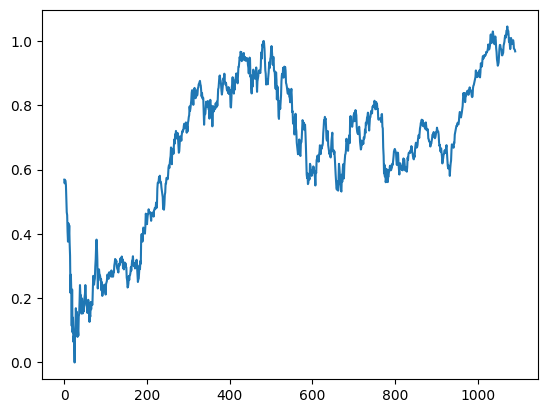

In [9]:
plt.plot(datos['Financial_Sector_Close'])
plt.show()

## Modelo

<!-- Modelos -->

In [12]:
T = 3 # Segmentos
X = list()
y = list()

for t in range(len(datos) - T):
    
    # Toma valores de X de t en t con stride de 1
    x = datos[t : t + T]
    X.append(x)
    
    # Toma los valores de t en t
    y_ = datos.iloc[t + T, -1]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X = np.array(X).reshape(-1, T, datos.shape[1] ) ##  ndim = datos.shape[1]

y = np.array(y).reshape(-1, 1, 1 ) 

print(f"X: {X.shape}\ty: {y.shape}")

X: (1088, 3, 9)	y: (1088, 1, 1)


In [23]:
## Modelo
    
def trading():
    
    model = Sequential()

    model.add(Input(shape = (T, datos.shape[1]))) # T, 1) en lugar 1 sería ndim datos.shape[1]

    model.add(LSTM(units = 512, activation = "relu"))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1024, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units = 256, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation = "relu")) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 32, activation = "relu")) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 16, activation = "relu")) 

    model.add(Dense(units = 1))

    model.compile(optimizer = "adam", loss = "mse")
    return model
    

model = trading()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,069,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,841 (7.16 MB)

 Trainable params: 1,875,841 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# from keras.layers import Dense, LSTM, Dropout, Input
# from keras.regularizers import l2

In [53]:
# def trading():
#     model = Sequential()
    
#     model.add(Input(shape=(T, datos.shape[1])))  # T, datos.shape[1]
#     model.add(LSTM(units=512, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=256, activation='relu'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dense(units=1))
    
#     model.compile(optimizer='adam', loss='mse')
#     return model

# model = trading()
# model.summary()

In [24]:
model = trading()

earlystopping = EarlyStopping(
    min_delta=0.000001, 
    patience=100
)
checkpoint = ModelCheckpoint(
    './model_trading.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    x = X[:len_train],
    y = y[:len_train],
    epochs = 1000,
    batch_size = 32,
    validation_data = (X[len_train:], y[len_train:]),
    verbose = 1
    ,callbacks = [checkpoint, earlystopping]
)

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2487
Epoch 1: val_loss improved from inf to 0.03964, saving model to ./model_trading.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.2450 - val_loss: 0.0396
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0251
Epoch 2: val_loss improved from 0.03964 to 0.01096, saving model to ./model_trading.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0251 - val_loss: 0.0110
Epoch 3/1000
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0225
Epoch 3: val_loss improved from 0.01096 to 0.00693, saving model to ./model_trading.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0223 - val_loss: 0.0069
Epoch 4/1000
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0156
Epoch 4: val_loss did not improve from 0.00693
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0156 - val_loss: 0.0184
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0147
Epoch 5: val_loss did not improve from 0.00693
28/2

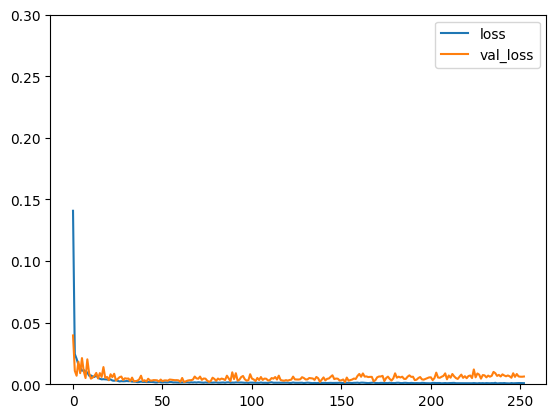

In [25]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.ylim(0, 0.3)
plt.show()

In [120]:
type(df_trading_input.iloc[-1, 5])

str

In [61]:
# "1 - Step Predictions"

# Toma un valor y predice el siguiente

validation_target = y[len_train:]
validation_predictions = list()

i = len_train

while len(validation_predictions) < len(validation_target):
    
    # Predice el siguiente valor de X[i]
    # p = model.predict(X[i].reshape(1, -1, 1))[0] [:n_days_pred] 
    p = model.predict((X[i]).reshape(1, -1, datos.shape[1]))
    i += 1
    
    validation_predictions.append(p)
    

ValueError: cannot reshape array of size 27 into shape (1,1,9)

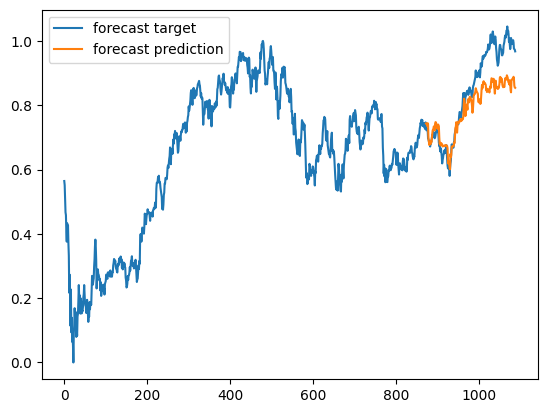

In [27]:

validation_predictions = np.array(validation_predictions)
yy = y.flatten()
espacio = len(y[:len_train].flatten())
valid = validation_predictions.flatten()
plt.plot(np.arange(len(yy)), yy, label="forecast target")  # Datos históricos
plt.plot(np.arange(espacio, espacio + len(valid)), valid, label="forecast prediction")  # Predicciones

plt.legend()
plt.show()

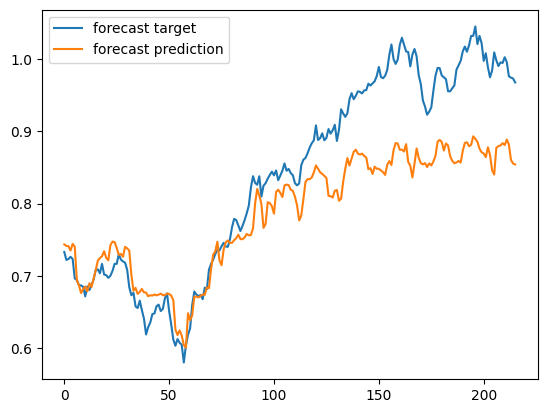

In [28]:
validation_predictions = np.array(validation_predictions)
#plt.plot(datos[920:],label = "datos")
plt.plot(validation_target.flatten(), label = "forecast target")
plt.plot(validation_predictions.flatten(), label = "forecast prediction")
# for i in range(validation_predictions.shape[1]):
#     plt.plot(validation_predictions[:, i], label=f"day {i+1} forecast prediction")
plt.legend()
plt.show()


In [341]:
validation_target_ = y_scaler.inverse_transform(validation_target.reshape(-1, 1))
validation_predictions_ = y_scaler.inverse_transform(validation_predictions.reshape(-1, 1))

In [98]:
 # 5.1.- Grafico 1
    # Definir vbles
yy = y.flatten()
validation_p = validation_predictions.flatten()     
espacio = len(yy[:len_train]) 

dates_str = df_trading_input['date'].dt.strftime('%Y-%m-%d')
# Crear un DataFrame para Plotly Express
data_graf_1 = {
    'Index': np.concatenate((np.arange(len(yy)), np.arange(espacio, espacio + len(validation_p)))),
    'Value': np.concatenate((yy, validation_p)),
    'Type': ['forecast target'] * len(yy) + ['forecast prediction'] * len(validation_p)
}
df_graf_1 = pd.DataFrame(data_graf_1)
# Crear el gráfico usando Plotly Express
fig_1 = px.line(df_graf_1, x='Index', y='Value', color='Type', 
            labels={'Value': 'USD$', 'Index': 'Time (days)'}, 
            title='XLF. Financial Select Sector. Forecast vs Prediction',
            color_discrete_map={'forecast target': 'red', 'forecast prediction': 'blue'})

fig_1.show()

In [286]:
# a=np.array(df_trading_input['Financial_Sector_Close'][:len_train])
# scaler.fit_transform(a.reshape(-1, 1))
y_pred = y_scaler.inverse_transform(validation_predictions.reshape(-1, 1))
y_pred
# guardar resultado modelo
with open('../models/y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f) 

array([[30.182152],
       [30.136871],
       [29.97208 ],
       [29.271044],
       [28.519878],
       [27.87345 ],
       [26.659899],
       [26.30091 ],
       [26.487158],
       [26.912584],
       [26.247377],
       [25.567913],
       [24.986673],
       [24.317001],
       [23.992619],
       [23.583366],
       [22.95123 ],
       [22.858057],
       [22.202894],
       [21.951849],
       [21.530853],
       [21.659552],
       [21.794357],
       [21.839687],
       [22.235138],
       [22.515734],
       [22.807497],
       [22.688929],
       [22.675816],
       [22.632364],
       [22.474098],
       [22.509794],
       [22.543713],
       [22.824192],
       [23.006144],
       [23.269697],
       [23.683397],
       [23.820004],
       [23.84991 ],
       [23.601381],
       [23.457273],
       [23.563635],
       [23.53564 ],
       [23.38084 ],
       [23.284657],
       [23.28248 ],
       [23.370546],
       [23.68122 ],
       [23.82134 ],
       [23.930405],


In [160]:
X[len_train][-1][datos.shape[1]-1]

0.6298831347683437

In [42]:
(X[i]).reshape(1, -1, datos.shape[1])

array([[[0.04409103, 0.01103469, 0.03518199, 0.47370106, 0.53024477,
         0.        , 0.        , 0.        , 0.56860274],
        [0.10805905, 0.02751505, 0.03391606, 0.48265158, 0.54057184,
         0.01136364, 0.        , 0.        , 0.55723909],
        [0.05861897, 0.02106621, 0.03553972, 0.48784571, 0.54105778,
         0.01136364, 0.        , 0.        , 0.5669192 ]]])

In [2]:
# "Multiple - Step Predictions"

# Toma el último valor de una serie y predice el siguiente
# Usa esa predicción para seguir haciendo predicciones.
n_days_pred=250  #ELIMINAR este valor se definirá arriba
validation_target = y[len_train:]
validation_predictions = list()
last_x = X[len_train]

for i in range(n_days_pred):
    if len(validation_predictions) < len(validation_target):

        # En la primera iteración predice el siguiente valor de usando X
        # En las siguientes iteraciones usa el valor predicho anterior para predecir el siguiente
        
        p = model.predict(X[i].reshape(1, -1, datos.shape[1]))[0,0]
        validation_predictions.append(p)
        valor_target = last_x[-1][datos.shape[1]-1]
        
        print(f"Valor: {valor_target}\tPredicción: {p}")
        # Desplaza los elementos en last_x hacia atrás (en esta caso desplazamos toda la fila), dejando el primer elemento al final
        last_x = np.roll(last_x, -1, axis=0)
        
        # Cambia el último elemento a la predicción
        # en este caso se cambia solo el valor a predecir y se mantienen invariables los últimos valores de los demás parámetros
        # estos valores (análisis de sentiniento, VIX, alpha, beta...) serán los del último día conocido e iguales para los n_days_pred de la predicción
        # last_x[-1][datos.shape[1]-1] = p
        last_x[-1][-1] = p

NameError: name 'y' is not defined

In [3]:
plt.plot(validation_target.flatten(), label = "forecast target")

plt.plot((validation_predictions), label = "forecast prediction")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# # guardar resultado modelo
# with open('history.pkl', 'wb') as f:
#     pickle.dump(history.history, f) 

In [ ]:
# cargar resultado modelo
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [11]:
# # Ruta del archivo del modelo guardado
# Cargar el modelo guardado
model = load_model('../models/model_trading.keras', compile=False)
model.compile(optimizer = "adam", loss = "mse")
# Mostrar el resumen del modelo para verificar que se cargó correctamente
type(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 512)            │     1,069,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,841 (7.16 MB)

 Trainable params: 1,875,841 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

NoneType

In [106]:
model_summary_df = get_model_summary()

NameError: name 'get_model_summary' is not defined

In [48]:
confusion_matrix(y_test, ypred)

array([[ 64,  37,  47],
       [ 40, 587,  93],
       [ 25, 107, 331]], dtype=int64)